<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/FasionMnist_chainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FasionMnist_chainer

<table class="tfo-notebook-buttons" align="left" >
 <td>
<img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
  <td>
<img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
  </td>
</table>


https://chainer-colab-notebook.readthedocs.io/ja/latest/notebook/hands_on/chainer/begginers_hands_on/00_How_to_use_chainer_on_colaboratory.html

In [2]:
!nvidia-smi
!ls

Wed Dec 19 06:22:29 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   6156      0 --:--:-- --:--:-- --:--:--  6156
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


In [4]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: 2.0.0.post3


In [5]:
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

In [0]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer

In [0]:
LABEL_NAMES = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

def get_label_name(label):
    return LABEL_NAMES[label]

In [8]:
for i in range(len(LABEL_NAMES)):
    print(i, ' is ', get_label_name(i))

0  is  T-shirt/top
1  is  Trouser
2  is  Pullover
3  is  Dress
4  is  Coat
5  is  Sandal
6  is  Shirt
7  is  Sneaker
8  is  Bag
9  is  Ankle boot


In [9]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)

In [10]:
print('Size of train', len(train))
print('Size of test', len(test))

Size of train 60000
Size of test 10000


In [11]:

x, t = test[0]
print('Shape of x:', x.shape)
print('label:', t)
print('label name:', get_label_name(t))

Shape of x: (784,)
label: 9
label name: Ankle boot


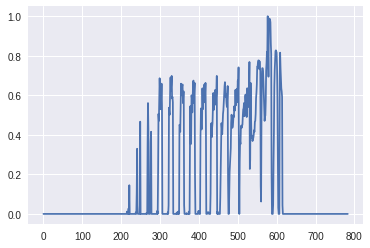

In [12]:
plt.plot(x)

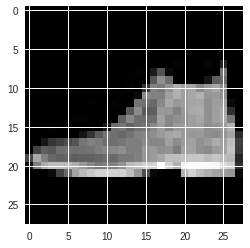

In [13]:
plt.imshow(x.reshape(28, 28), cmap='gray')

0 T-shirt/top


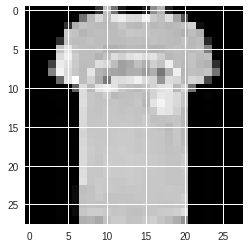

1 Trouser


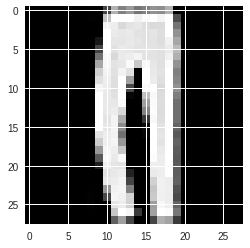

2 Pullover


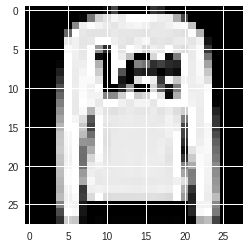

3 Dress


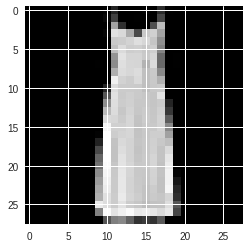

4 Coat


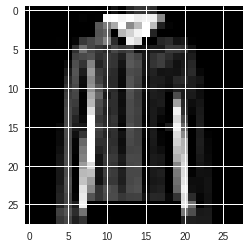

5 Sandal


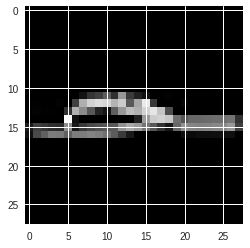

6 Shirt


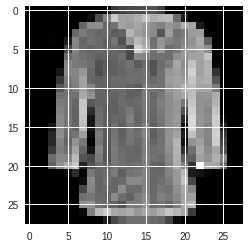

7 Sneaker


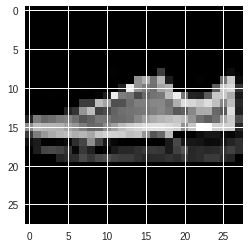

8 Bag


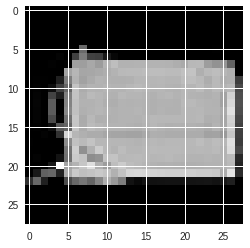

9 Ankle boot


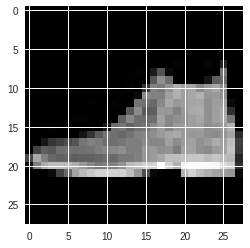

In [14]:
for label_name in LABEL_NAMES:
    this_data = ((x,t) for x, t in test if get_label_name(t) == label_name)  # generator
    x, t = next(this_data)
    print(t, label_name)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.show()

In [0]:
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import Chain

class MLP2(Chain):

    # Initialization of layers
    def __init__(self):
        super(MLP2, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)  # From 784-dimensional input to hidden unit with 200 nodes
            self.l2=L.Linear(200, 10)  # From hidden unit with 200 nodes to output unit with 10 nodes  (10 classes)

    # Forward computation
    def forward(self, x):
        h1 = F.tanh(self.l1(x))  # Forward from x to h1 through activation with tanh function
        y = self.l2(h1)  # Forward from h1to y
        return y

In [0]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device):

    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)

    # 2. Optimizerを設定する
    optimizer.setup(model)

    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)

    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')

    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))

    # 6. 訓練を開始する
    trainer.run()

In [0]:
device = 0  # specify gpu id. if device == -1, use cpu
n_epoch = 5  # Only 5 epochs
batchsize = 256

model = MLP2() # MLP2 model
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

In [19]:
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.42306     0.602121       1.04271        0.679297           10.6731       
2           0.913064    0.712841       0.843795       0.722656           13.5043       
3           0.780385    0.750641       0.755033       0.74873            16.3953       
4           0.709616    0.770707       0.698877       0.769141           19.2705       
5           0.663261    0.785978       0.66069        0.779785           22.0961       


In [0]:
import pydot
from IPython.display import Image, display

def show_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')
    display(Image('graph.png', width=600, height=600))

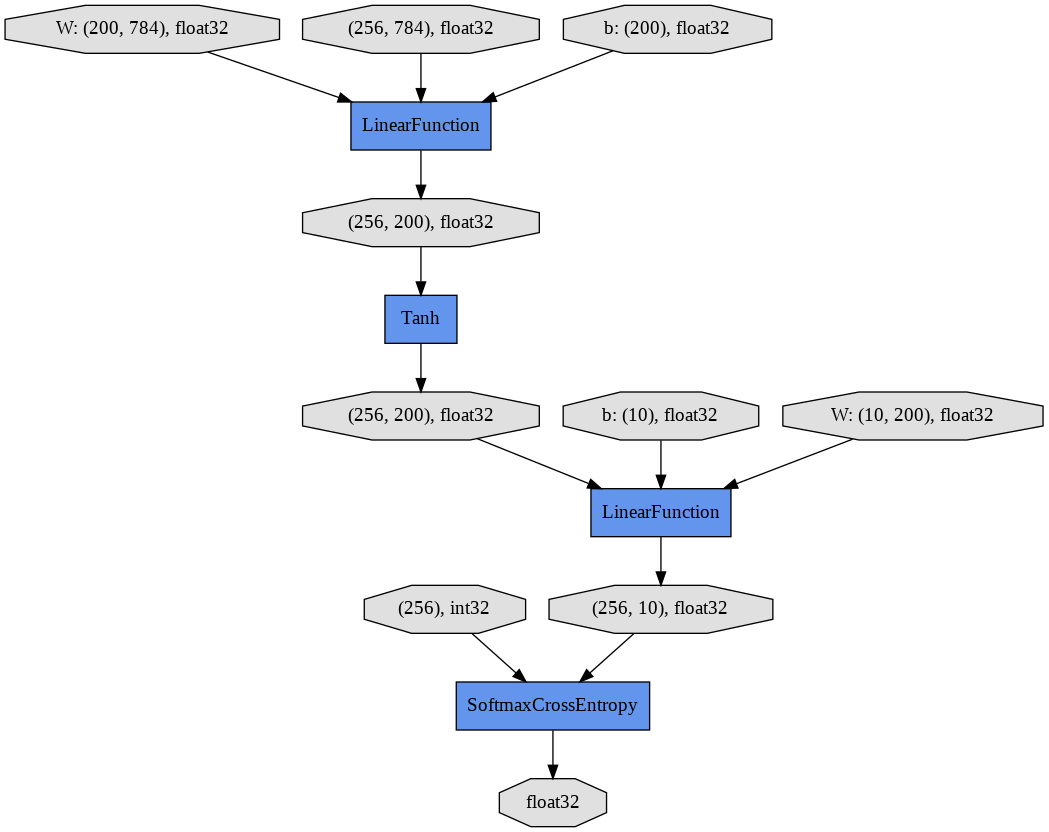

In [21]:
show_graph()

In [0]:
def show_loss_and_accuracy():
    display(Image(filename='out/loss.png'))
    display(Image(filename='out/accuracy.png'))

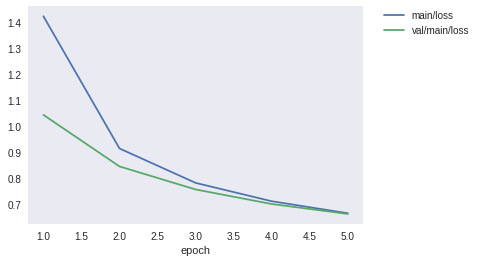

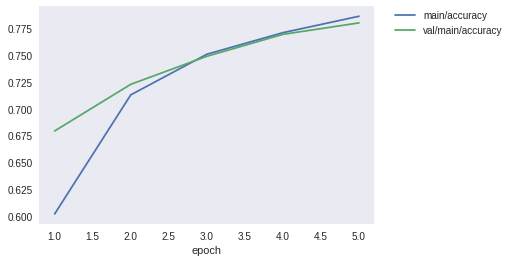

In [23]:
show_loss_and_accuracy()

In [0]:

from chainer import Variable

def show_examples(model, test, device):
    plt.figure(figsize=(12,50))
    if device >= 0:
        model.to_cpu()
    for i in range(45, 105):
        data, label = test[i]  # test data, label
        x = Variable(np.asarray([data]))
        t = Variable(np.asarray([label]))  # labels
        y = model(x)
        prediction = y.data.argmax(axis=1)
        example = (data * 255).astype(np.int32).reshape(28, 28)
        plt.subplot(20, 5, i - 44)
        plt.imshow(example, cmap='gray')
        plt.title("No.{0}\nAnswer:{1}\nPredict:{2}".format(
            i,
            get_label_name(label),
            get_label_name(prediction[0])
        ))
        plt.axis("off")
    plt.tight_layout()

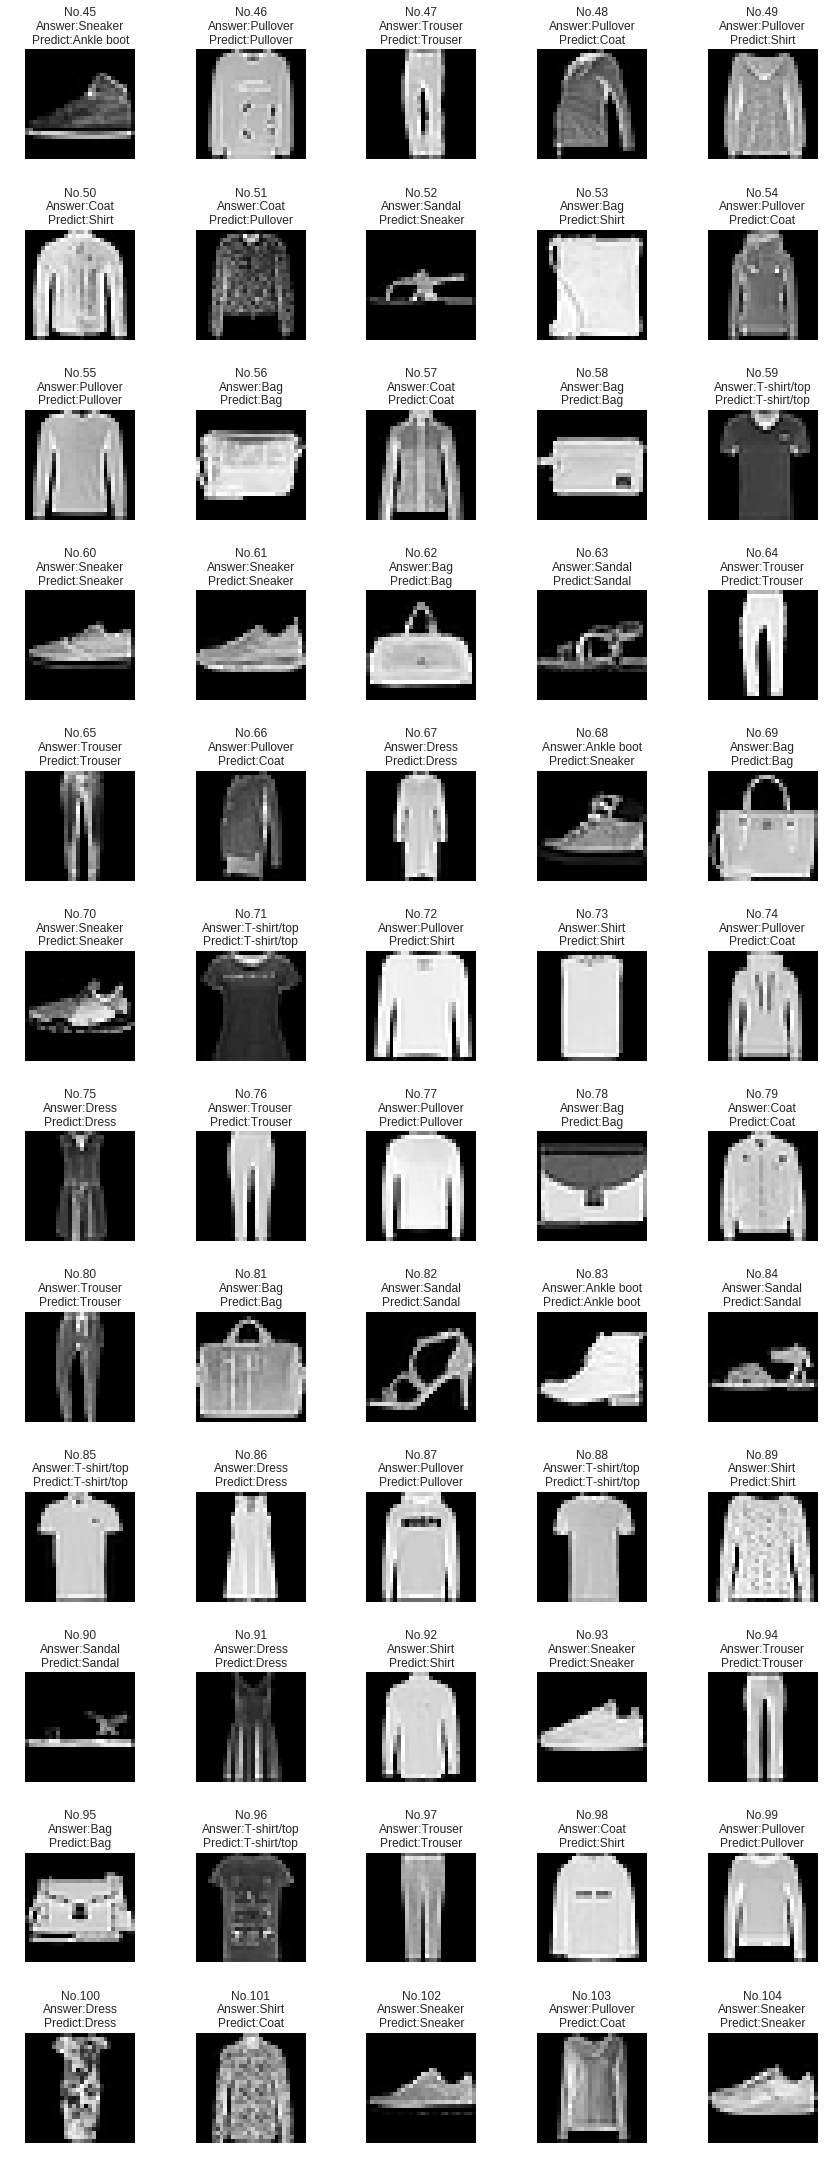

In [25]:
show_examples(model, test, device)

In [0]:
## 3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):

    def __init__(self):
        super(MLP3, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)
            self.l2=L.Linear(200, 200)   # Additional  layer
            self.l3=L.Linear(200, 10)

    def forward(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1)) # Hidden unit 2
        y = self.l3(h2)
        return y

In [27]:
device = 0
n_epoch = 5
batchsize = 256

model = MLP3()  # Use MLP3 instead of MLP2
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.36143     0.626216       0.979603       0.679199           2.87351       
2           0.8581      0.715124       0.796274       0.729199           6.10687       
3           0.734702    0.755769       0.711902       0.756641           9.35589       
4           0.666877    0.779257       0.658706       0.774902           12.6503       
5           0.621446    0.792949       0.621195       0.786035           16.0815       


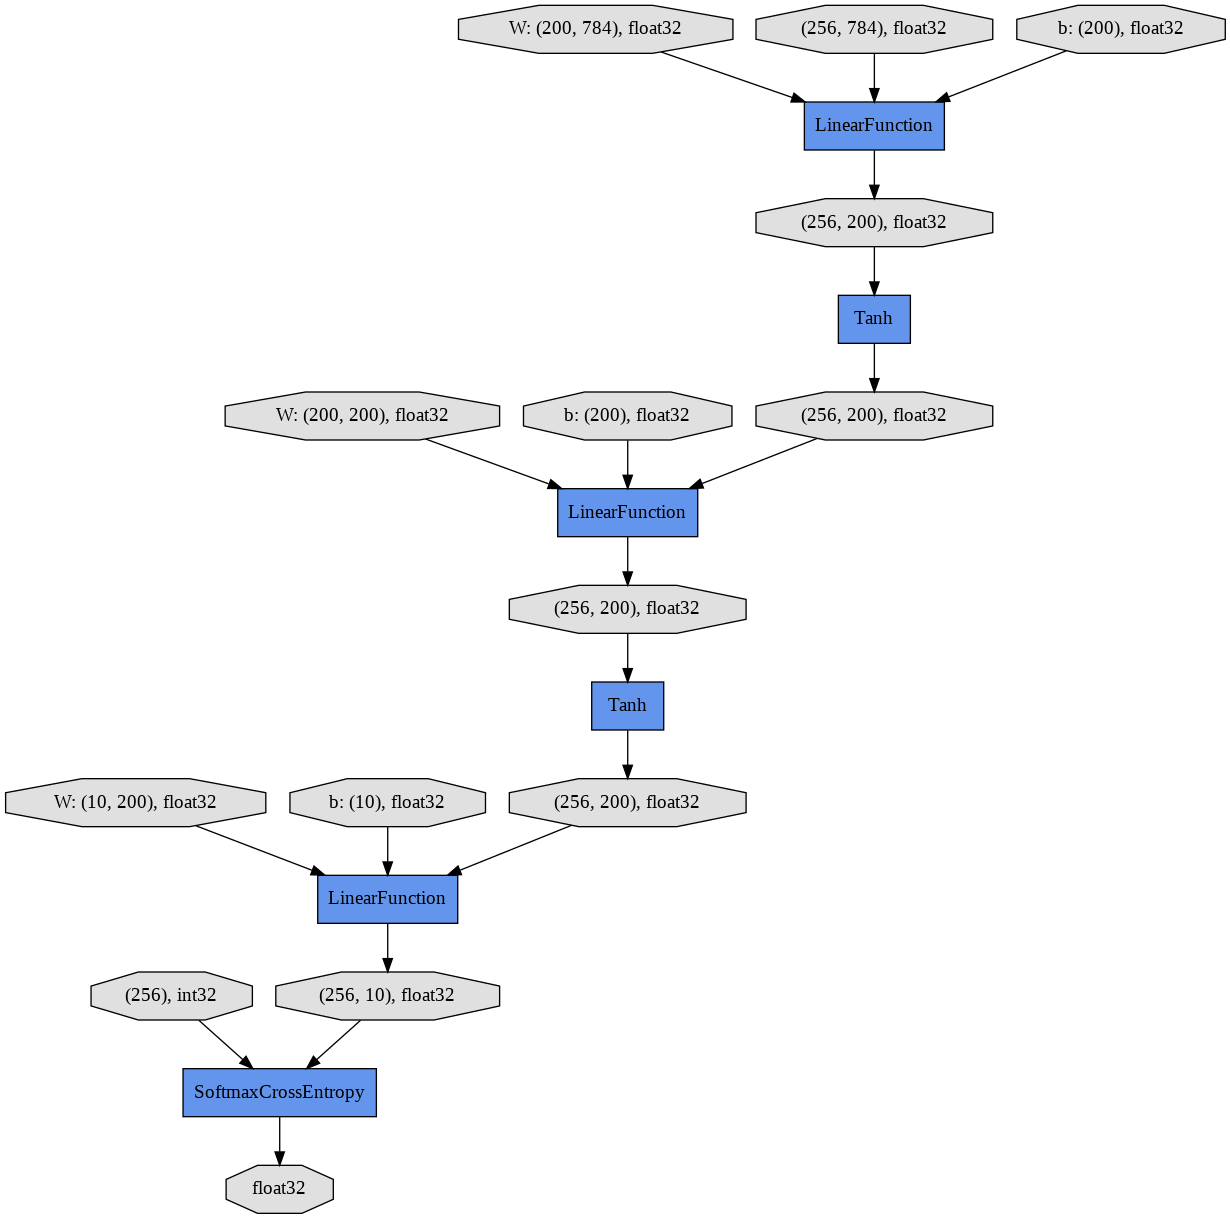

In [28]:
show_graph()

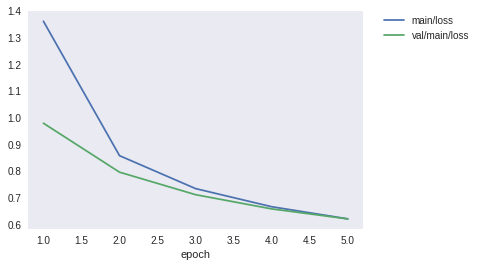

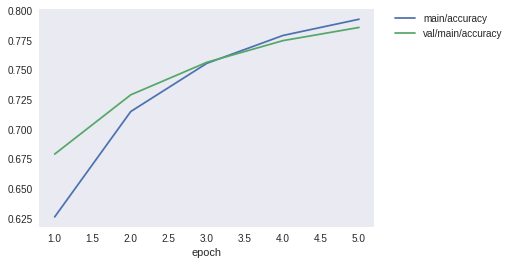

In [29]:
show_loss_and_accuracy()

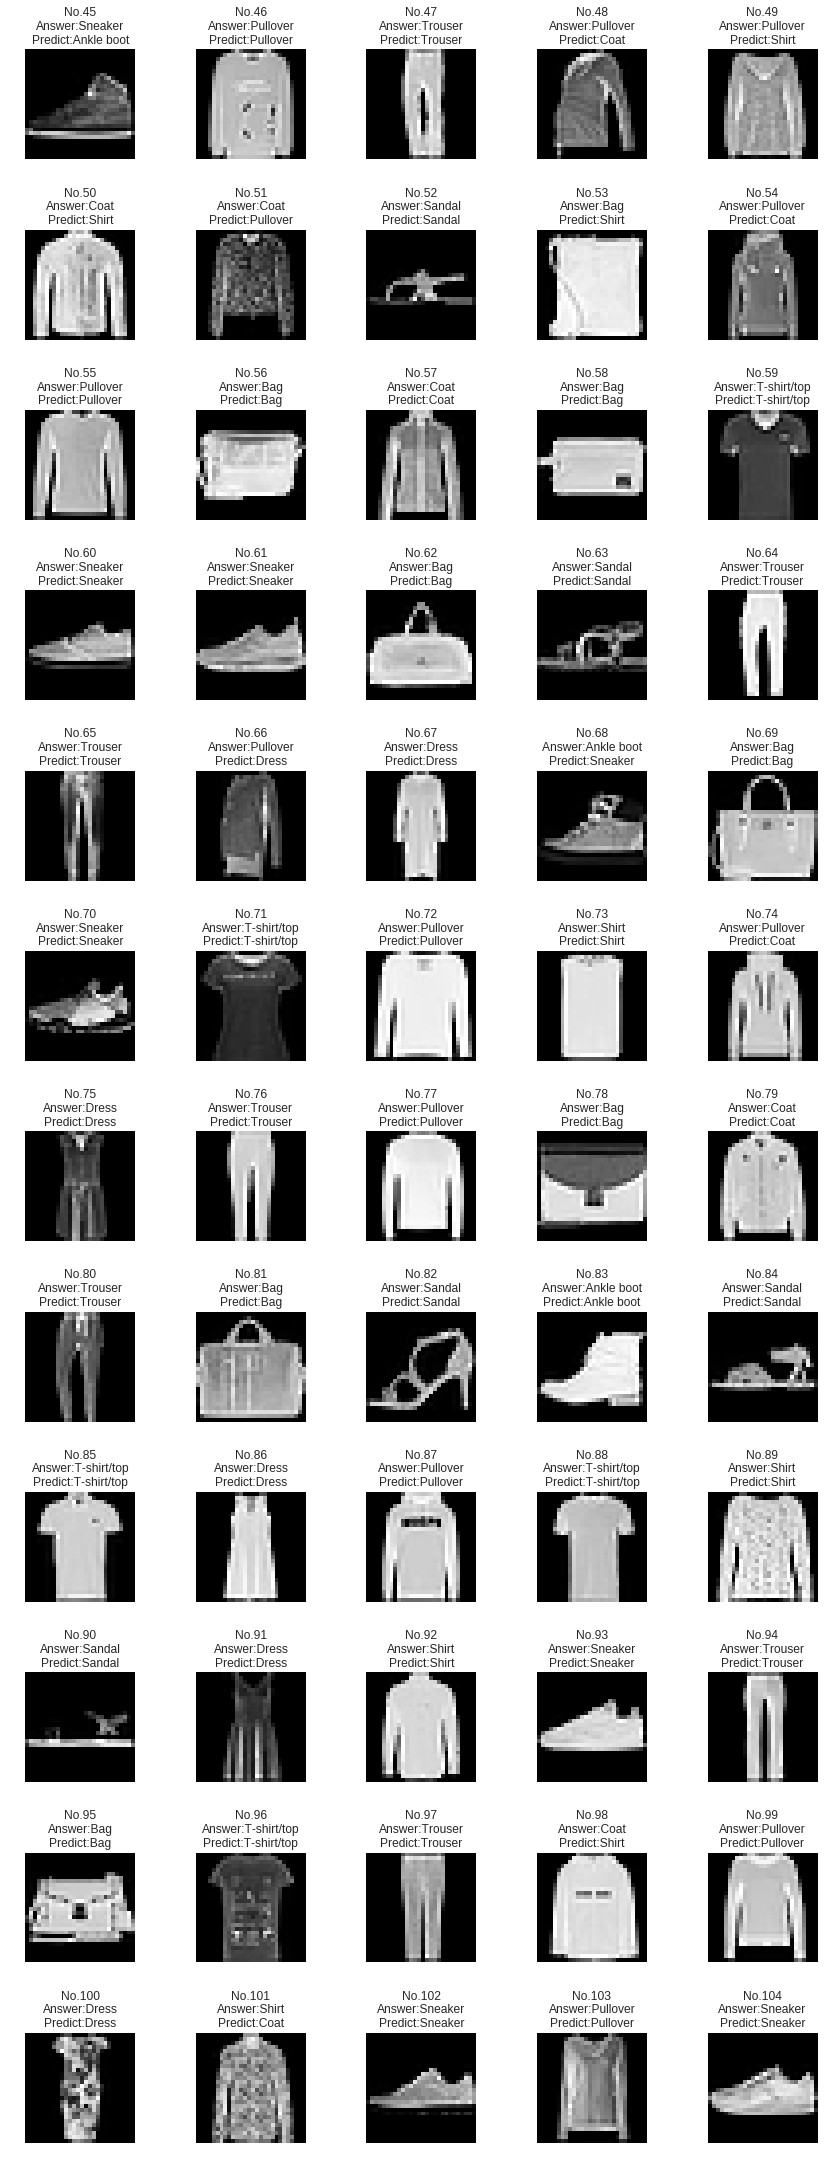

In [30]:
show_examples(model, test, device)